In [1]:
import pandas as pd

In [43]:
import matplotlib.pyplot as plt

def plot_model_comparison(df, title="Model Comparison"):
    """
    Plot a line chart comparing three models across four different setups.

    Parameters:
    df (pd.DataFrame): DataFrame with columns ['GeminiPro', 'Mistral', 'Deepseek']
                      and rows ['Monolithic', 'Duo', 'Manager', 'Team']
    """
    # Create the figure and axis
    plt.figure(figsize=(10, 6))

    # Reindex the dataframe to ensure correct order
    df = df.reindex(["Monolithic", "Duo", "Manager", "Team"])

    # Define colors for each model
    colors = {
        "GeminiPro": "#AB6E96", 
        "Mistral": "#DF7F42",
        "Deepseek": "#536AF5",
    }

    # Plot each model as a separate line
    for model in df.columns:
        plt.plot(
            df.index,
            df[model],
            marker="o",
            linewidth=2,
            markersize=6,
            color=colors[model],
            label=model,
        )

    # Customize the plot
    plt.xlabel("Multi-Agent System", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.title(
        title, fontsize=14, fontweight="bold"
    )
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)

    # Rotate x-axis labels if needed for better readability
    #plt.xticks(rotation=45)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    # Show the plot
    plt.show()

# Average Performance
How many bpmn features could the different models reconstruct?

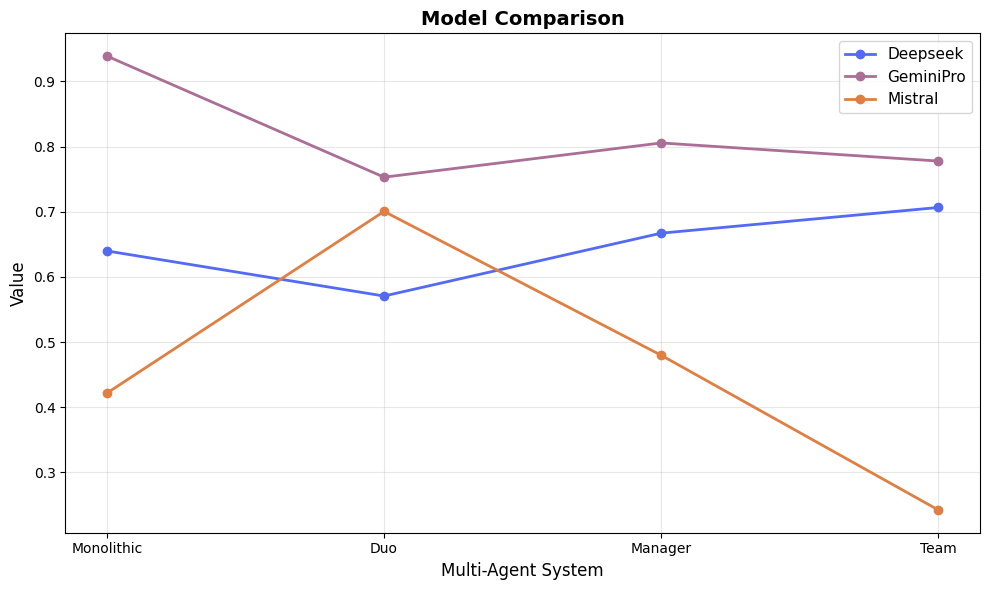

In [44]:
shop_features = pd.read_csv('shop-features.csv', index_col=0, header=[0,1], sep=',') 
hotel_features = pd.read_csv('hotel-features.csv', index_col=0, header=[0,1], sep=',') 
reimbursement_features = pd.read_csv('reimbursement-features.csv', index_col=0, header=[0,1], sep=',') 
features = pd.concat([shop_features.mean(), hotel_features.mean(), reimbursement_features.mean()], axis=1).mean(axis=1)
features = features.reset_index().pivot_table(
    index="level_1",
    columns="level_0",
    values=0,
)

plot_model_comparison(features)